In [1]:
from torchmetrics import Accuracy

c:\Users\Admin\anaconda3\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\Admin\anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt

In [3]:
os.chdir("../Dataset")

In [4]:
dataset = pd.read_csv("FeatureExtracted/dataset.csv")
ratings_train = pd.read_csv("CleanedData/ratings_train.csv")
ratings_test = pd.read_csv("CleanedData/ratings_test.csv")

## Content-Based Recommendation System - Pytorch

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# import torchvision
# import torchvision.transforms as transforms

### Make Dataset For Train

There are 671 users

In [6]:
len_users = len(ratings_train['userId'].unique())
print(len_users)

671


2830 movies

In [7]:
len_dataset = len(dataset)
print(len_dataset)

2830


We need to save the id for later recommendation

In [8]:
dataset

,budget,id,runtime,revenue,vote_average,vote_count,CastsRank,NumLeadActors,HasTop50Actors,NumCrews,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,60000000,949,170.0,187436818.0,7.7,1886.0,13852,3,0,71,...,0,0,0,0,0,0,0,1,0,0
1,58000000,710,130.0,352194034.0,6.6,1194.0,5916,3,1,46,...,0,0,0,0,0,0,0,1,0,0
2,98000000,1408,119.0,10017322.0,5.7,137.0,3481,0,0,16,...,0,0,0,0,0,0,0,0,0,0
3,52000000,524,178.0,116112375.0,7.8,1343.0,6894,0,0,10,...,0,0,0,0,0,0,0,0,0,0
4,16500000,4584,136.0,135000000.0,7.2,364.0,4392,2,1,8,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2825,0,80831,121.0,0.0,6.5,2.0,1374,0,0,4,...,0,0,0,0,0,0,0,0,0,0
2826,0,3104,92.0,0.0,5.9,33.0,1054,0,0,11,...,0,1,0,0,0,1,0,0,0,0
2827,0,64197,97.0,0.0,6.0,5.0,729,0,0,4,...,0,0,0,0,1,0,0,0,0,0
2828,0,98604,91.0,0.0,4.6,6.0,2385,0,0,4,...,0,0,0,0,1,0,0,0,0,0


In [9]:
indexToId = dict(zip(dataset.index, dataset['id']))
idToIndex = dict(zip(dataset['id'], dataset.index))

In [10]:
indexToId[0]

949

In [11]:
dataset.drop(columns = ['id'], inplace = True)

In [12]:
from sklearn import preprocessing

In [13]:
dataset = preprocessing.scale(dataset)

In [14]:
len_features = dataset.shape[1]

Test Transfrom Metadata Movies Dataframe to Tensor

In [15]:
movies_tensor = torch.tensor(dataset, requires_grad= False)

Test Transform Ratings to Sparse Tensor

In [16]:
ratings_train["movieId"] = ratings_train["movieId"].apply(lambda x: idToIndex[x])

In [17]:
ratings_test["movieId"] = ratings_test["movieId"].apply(lambda x: idToIndex[x])

In [18]:
len(ratings_train['userId'].unique()) == len(ratings_test['userId'].unique())

True

In [19]:
ratings_train["userId"] = ratings_train["userId"].apply(lambda x: x - 1)
ratings_test["userId"] = ratings_test["userId"].apply(lambda x: x - 1)

In [20]:
ratings_tensor = torch.sparse_coo_tensor([ratings_train['userId'], ratings_train['movieId']], ratings_train['rating'], (len_users, len_dataset))

All works normally!

Now we will put all those codes into one block

Rating larger than 4.0 will be assigned by **2** else **1**. 2 and 1 because we want to avoid the misunderstanding of library with 0 for the unrated one

In [21]:
ratings_train['rating'] = ratings_train['rating'].apply(lambda x: 2 if x >= 4 else 1)
ratings_test['rating'] = ratings_test['rating'].apply(lambda x: 2 if x >= 4 else 1)

Convert dataset to Tensor data structure

In [22]:
movies_tensor = torch.tensor(dataset, requires_grad= False)
movies_tensor = torch.cat((movies_tensor, torch.ones(len_dataset, 1, dtype = torch.float64)), axis = 1)
ratings_train_tensor = torch.sparse_coo_tensor([ratings_train['userId'],\
                                                     ratings_train['movieId']],\
                                                     ratings_train['rating'], (len_users, len_dataset))
ratings_test_tensor = torch.sparse_coo_tensor([ratings_test['userId'],\
                                                     ratings_test['movieId']],\
                                                     ratings_test['rating'], (len_users, len_dataset))

ratings_train_tensor = ratings_train_tensor.to_dense()
ratings_test_tensor = ratings_test_tensor.to_dense()

In [23]:
from torch.autograd import Variable

In [24]:
ratings_train_tensor[0][474]

tensor(1)

### Train

We proposed a Regression Model for predicting Ratings

To predict the rate from user model $U$ and movies profiles $M$:

$U$ * $M^\top$ = $\hat{R}$ 

$L = BCE(\hat{R}, R)$ for all movies that have rated 

Find the partial derivatives for matrix $U$ : $ \dfrac{\partial L}{\partial U} $

Update $U$ based on $ \dfrac{\partial L}{\partial U} $

To calculate derivatives, we use **Autograd** of ***Pytorch***

In [25]:
"""
Autograd example
"""
# ratings_pred = torch.matmul(torch.cat((U, b), axis = 1), movies_tensor.T)
# mask = ratings_train_tensor.bool()
# nonzero_pred = F.sigmoid(ratings_pred.masked_select(mask))
# nonzero_train = ratings_train_tensor.masked_select(mask)
# loss = criterion(nonzero_pred, nonzero_train)
# loss.backward()

'\nAutograd example\n'

In [26]:
U = Variable(torch.randn(len_users, len_features, dtype = torch.float64), requires_grad=True)
b = Variable(torch.randn(len_users, 1, dtype = torch.float64), requires_grad=True)

Here we use BCELoss (**Binary Cross Entropy Loss**) for classification 0 and 1

Metrics use is `accuracy`.

In [27]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam([U], lr = 0.005)
optimizer.add_param_group({'params': b, "lr": 0.005, "weight_decay": 0})

In [28]:
from tqdm.notebook import tqdm

In [29]:
bestU = None
bestb = None
maxAcc = 0.0

First try 3001 loop without regulization, lr = 0.005

In [30]:
EPOCH = 3001
a = Accuracy()
trainLoss = []
testLoss = []
testEp = []
trainAcc = []
testAcc =[]
for ep in tqdm(range(EPOCH)):
    optimizer.zero_grad()
    ratings_pred = torch.matmul(torch.cat((U, b), axis = 1), movies_tensor.T)
    mask = ratings_train_tensor.bool()
    nonzero_pred = F.sigmoid(ratings_pred.masked_select(mask))
    nonzero_train = ratings_train_tensor.masked_select(mask)
    nonzero_train = nonzero_train - 1
    loss = criterion(nonzero_pred, nonzero_train.double())
    accuracy = a(nonzero_pred, nonzero_train.int())
    loss.backward()
    optimizer.step()

    trainLoss.append(loss.item())
    trainAcc.append(accuracy.item())
    if ep % 10 == 0:
      mask = ratings_test_tensor.bool()
      nonzero_pred = F.sigmoid(ratings_pred.masked_select(mask))
      nonzero_test = ratings_test_tensor.masked_select(mask)
      nonzero_test = nonzero_test - 1
      loss_test = criterion(nonzero_pred, nonzero_test.double())
      accuracy_test = a(nonzero_pred, nonzero_test.int())

      testEp.append(ep)
      testLoss.append(loss_test.item())
      testAcc.append(accuracy_test.item())
      
      if maxAcc < accuracy_test:
        bestU = U
        bestb = b
        maxAcc = accuracy_test
      print(f'Epoch: {ep}. Train Loss: {loss}. Train Acc: {accuracy}. Valid Loss: {loss_test}. Valid Acc: {accuracy_test}.')


  0%|          | 0/3001 [00:00<?, ?it/s]

Epoch: 0. Train Loss: 2.5659123538704156. Train Acc: 0.49807631969451904. Valid Loss: 2.551373500559264. Valid Acc: 0.5013406872749329.
Epoch: 10. Train Loss: 2.3617002067796014. Train Acc: 0.5088489651679993. Valid Loss: 2.4377209516513405. Valid Acc: 0.5019928812980652.
Epoch: 20. Train Loss: 2.178715865185289. Train Acc: 0.5204553008079529. Valid Loss: 2.3309321674550314. Valid Acc: 0.5027900338172913.
Epoch: 30. Train Loss: 2.012982422458307. Train Acc: 0.5297852158546448. Valid Loss: 2.2447472547335727. Valid Acc: 0.5038771033287048.
Epoch: 40. Train Loss: 1.8620849818579364. Train Acc: 0.5401090383529663. Valid Loss: 2.163985960489234. Valid Acc: 0.5048192143440247.
Epoch: 50. Train Loss: 1.7230781336991914. Train Acc: 0.5509137511253357. Valid Loss: 2.0967569004489777. Valid Acc: 0.5061236023902893.
Epoch: 60. Train Loss: 1.5953969045255516. Train Acc: 0.5622314810752869. Valid Loss: 2.0376826055742994. Valid Acc: 0.5074280500411987.
Epoch: 70. Train Loss: 1.4845099061488731. Tr

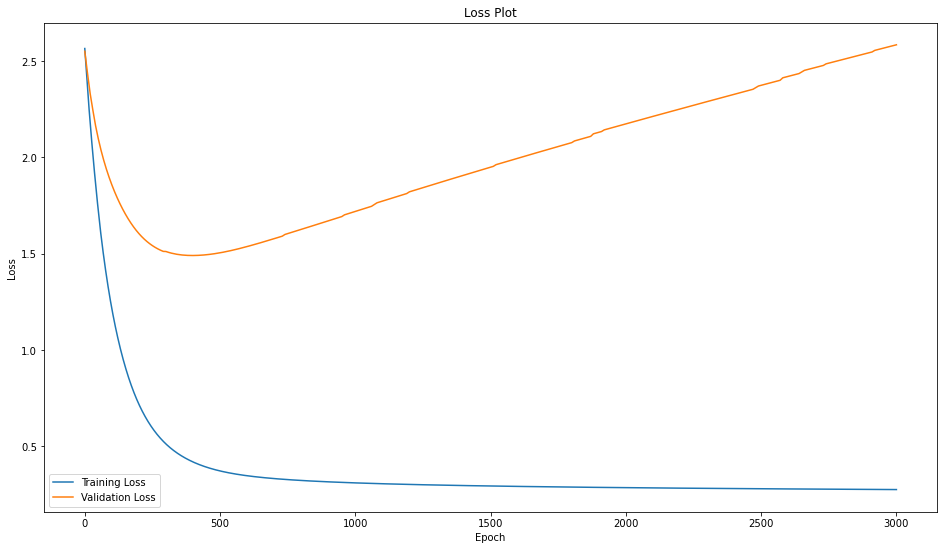

In [31]:
fig = plt.figure(figsize = (16,9))
numOfEpoch = 3001
plt.plot(np.arange(0, numOfEpoch), trainLoss, label='Training Loss')
plt.plot(testEp, testLoss, label='Validation Loss')
plt.title('Loss Plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim((0.0,1.0))
plt.legend()

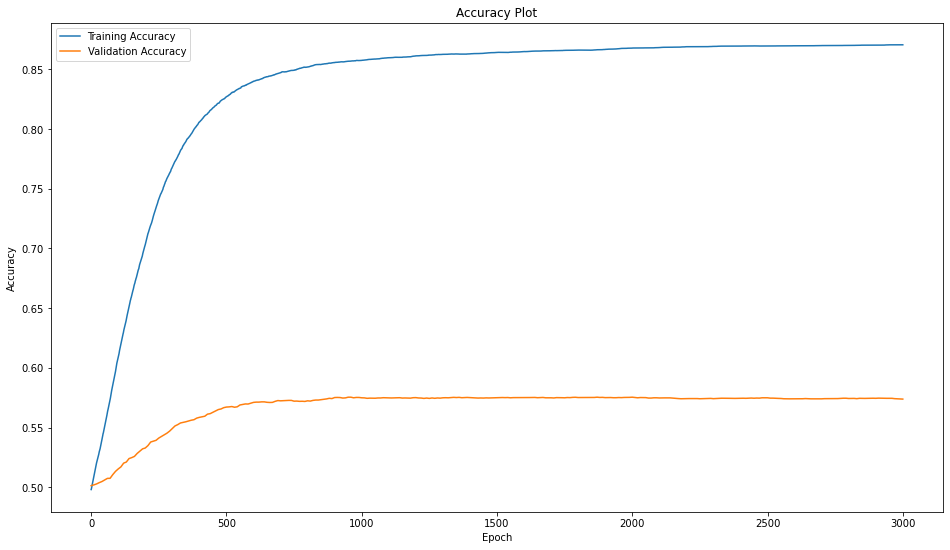

In [32]:
fig = plt.figure(figsize = (16,9))
numOfEpoch = 3001
plt.plot(np.arange(0, numOfEpoch), trainAcc, label='Training Accuracy')
plt.plot(testEp, testAcc, label='Validation Accuracy')
plt.title('Accuracy Plot')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim((0.0,1.0))
plt.legend()

Now apply regularization with lr = 0.005, weight_decay for U is 0.05

In [33]:
U = Variable(torch.randn(len_users, len_features, dtype = torch.float64), requires_grad=True)
b = Variable(torch.randn(len_users, 1, dtype = torch.float64), requires_grad=True)

In [34]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam([U], lr = 0.005, weight_decay = 0.005)
optimizer.add_param_group({'params': b, "lr": 0.005, "weight_decay": 0})

In [35]:
bestU = None
bestb = None
maxAcc = 0.0

In [36]:
EPOCH = 3001
a = Accuracy()
trainLoss = []
testLoss = []
testEp = []
trainAcc = []
testAcc = []
for ep in tqdm(range(EPOCH)):
    optimizer.zero_grad()
    ratings_pred = torch.matmul(torch.cat((U, b), axis = 1), movies_tensor.T)
    mask = ratings_train_tensor.bool()
    nonzero_pred = F.sigmoid(ratings_pred.masked_select(mask))
    nonzero_train = ratings_train_tensor.masked_select(mask)
    nonzero_train = nonzero_train - 1
    loss = criterion(nonzero_pred, nonzero_train.double())
    accuracy = a(nonzero_pred, nonzero_train.int())
    loss.backward()
    optimizer.step()

    trainLoss.append(loss.item())
    trainAcc.append(accuracy.item())
    if ep % 10 == 0:
      mask = ratings_test_tensor.bool()
      nonzero_pred = F.sigmoid(ratings_pred.masked_select(mask))
      nonzero_test = ratings_test_tensor.masked_select(mask)
      nonzero_test = nonzero_test - 1
      loss_test = criterion(nonzero_pred, nonzero_test.double())
      accuracy_test = a(nonzero_pred, nonzero_test.int())

      testEp.append(ep)
      testLoss.append(loss_test.item())
      testAcc.append(accuracy_test.item())
      
      if maxAcc < accuracy_test:
        bestU = U
        bestb = b
        maxAcc = accuracy_test
      print(f'Epoch: {ep}. Train Loss: {loss}. Train Acc: {accuracy}. Valid Loss: {loss_test}. Valid Acc: {accuracy_test}.')


  0%|          | 0/3001 [00:00<?, ?it/s]

Epoch: 0. Train Loss: 2.5569805048205234. Train Acc: 0.5039756298065186. Valid Loss: 2.5966262827824558. Valid Acc: 0.4949634075164795.
Epoch: 10. Train Loss: 2.442474453082978. Train Acc: 0.505995512008667. Valid Loss: 2.490494945551108. Valid Acc: 0.49655771255493164.
Epoch: 20. Train Loss: 2.33217046848684. Train Acc: 0.5082398056983948. Valid Loss: 2.388677363579942. Valid Acc: 0.49684759974479675.
Epoch: 30. Train Loss: 2.2226420669320337. Train Acc: 0.5092657804489136. Valid Loss: 2.291065953446026. Valid Acc: 0.4981520473957062.
Epoch: 40. Train Loss: 2.125950136516534. Train Acc: 0.5113497972488403. Valid Loss: 2.197975935823121. Valid Acc: 0.4994564950466156.
Epoch: 50. Train Loss: 2.0319113338513604. Train Acc: 0.5122795701026917. Valid Loss: 2.1045878378943477. Valid Acc: 0.5003260970115662.
Epoch: 60. Train Loss: 1.9445614435401377. Train Acc: 0.5146842002868652. Valid Loss: 2.0151536471585048. Valid Acc: 0.5010508298873901.
Epoch: 70. Train Loss: 1.8598214518266962. Train 

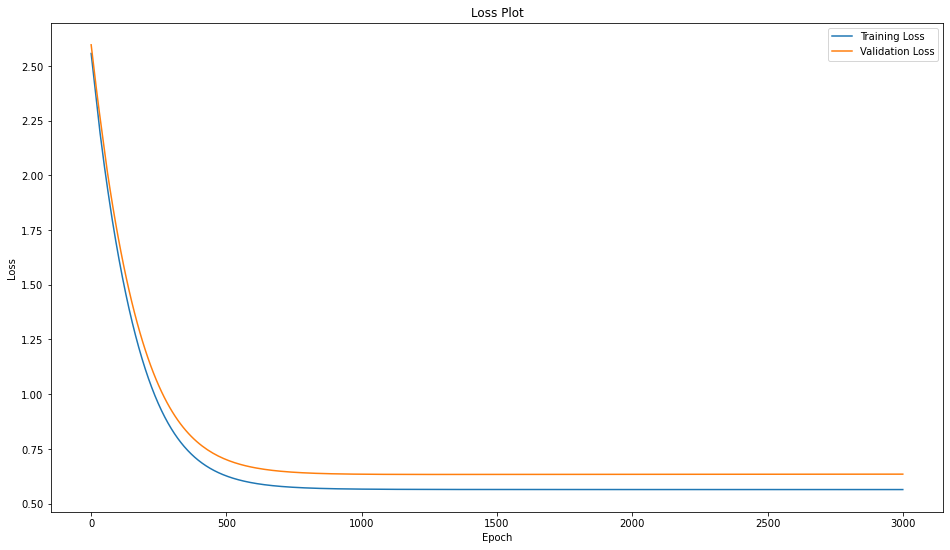

In [37]:
fig = plt.figure(figsize = (16,9))
numOfEpoch = 3001
plt.plot(np.arange(0, numOfEpoch), trainLoss, label='Training Loss')
plt.plot(testEp, testLoss, label='Validation Loss')
plt.title('Loss Plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim((0.0,1.0))
plt.legend()

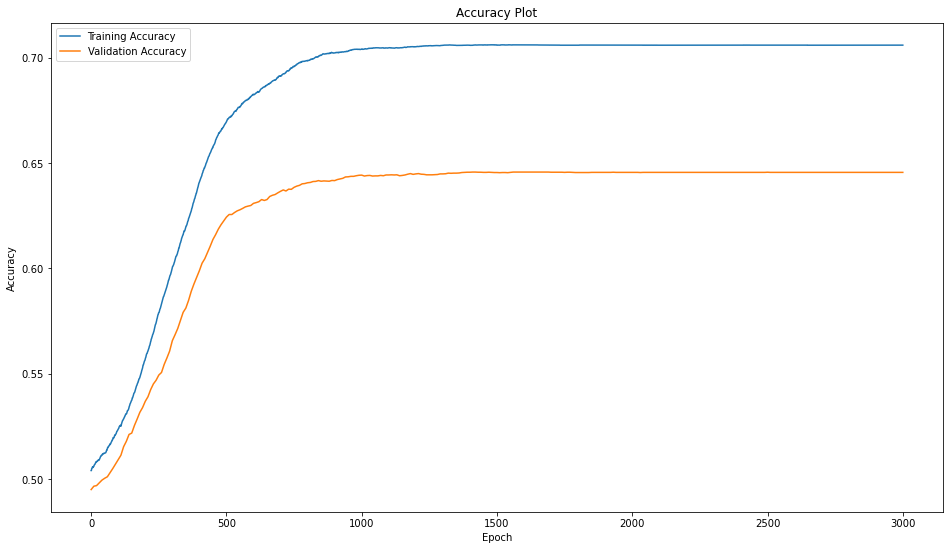

In [38]:
fig = plt.figure(figsize = (16,9))
numOfEpoch = 3001
plt.plot(np.arange(0, numOfEpoch), trainAcc, label='Training Accuracy')
plt.plot(testEp, testAcc, label='Validation Accuracy')
plt.title('Accuracy Plot')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim((0.0,1.0))
plt.legend()

Max Acc on Validation Test

In [39]:
maxAcc

tensor(0.6457)

In [40]:
bestU

tensor([[ 3.7451e-05,  2.9436e-05, -7.6236e-05,  ...,  1.5727e-04,
          4.9483e-05,  4.1296e-05],
        [-1.2024e-02, -3.4009e-02,  7.2701e-03,  ...,  6.3200e-03,
          5.4529e-03, -2.5529e-15],
        [ 7.4308e-03,  4.4527e-03, -4.4797e-03,  ...,  1.3246e-03,
         -9.2589e-03, -3.9062e-13],
        ...,
        [ 1.0040e-02,  2.6597e-03,  3.9776e-03,  ...,  6.1828e-03,
          4.4480e-16,  3.3120e-16],
        [ 2.8021e-03, -3.9962e-03,  1.4460e-04,  ..., -1.6241e-03,
          1.6042e-02,  3.9622e-19],
        [ 1.2498e-02, -6.5744e-03,  1.0276e-02,  ...,  1.3977e-02,
         -2.5654e-02, -3.7415e-02]], dtype=torch.float64, requires_grad=True)

In [41]:
bestU.detach().numpy().tofile("ModelStorage/U.txt")
bestb.detach().numpy().tofile("ModelStorage/b.txt")

In [42]:
with open("ModelStorage/indexToId.txt", "w+") as file:
  file.write(str(indexToId))
with open("ModelStorage/idToIndex.txt", "w+") as file:
  file.write(str(idToIndex))